In [1]:
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
import warnings
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from scipy.stats import binned_statistic_2d
import time
import pandas as pd
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
pd.set_option("display.max_columns", None)
def progress(message):
    print(f"[{time.strftime('%H:%M:%S')}] {message}")

In [2]:
#global vars
year_start = 2014
year_end = 2023
min_shots = 500
grid_size = 1
adv_grid_size = 2
max_distance = 35

In [3]:
#data import / cleaning


shotdata = pd.read_csv('DomSamangy - github - NBA_2004_2024_Shots.csv/NBA_2004_2024_Shots.csv')

shotdata['ACTION_TYPE'] = shotdata['ACTION_TYPE'].str.strip().str.lower()

shot_categories = {
    'jumper': {'fadeaway bank shot', 'jump bank shot', 'jump shot', 'no shot'},
    'moving': {'driving jump shot', 'fadeaway jump shot', 'floating jump shot', 
               'pullup bank shot', 'pullup jump shot', 'running jump shot', 
               'running pull-up jump shot', 'step back bank jump shot', 'step back jump shot', 
               'turnaround bank shot', 'turnaround fadeaway bank jump shot', 'turnaround fadeaway shot', 
               'turnaround finger roll shot', 'turnaround hook shot', 'turnaround jump shot'},
    'drive': {'driving bank hook shot', 'driving bank shot', 'driving dunk shot', 
              'driving finger roll layup shot', 'driving finger roll shot', 'driving floating bank jump shot', 
              'driving floating jump shot', 'driving hook shot', 'driving layup shot', 'driving reverse dunk shot', 
              'driving reverse layup shot', 'driving slam dunk shot', 'finger roll shot'},
    'rim': {'alley oop dunk shot', 'alley oop layup shot', 'cutting dunk shot', 
            'cutting finger roll layup shot', 'cutting layup shot', 'dunk shot', 
            'finger roll layup shot', 'follow up dunk shot', 'hook bank shot', 
            'hook shot', 'jump bank hook shot', 'jump hook shot', 
            'layup shot', 'putback dunk shot', 'putback layup shot', 
            'putback reverse dunk shot', 'putback slam dunk shot', 'reverse dunk shot', 
            'reverse layup shot', 'reverse slam dunk shot', 'slam dunk shot', 
            'tip dunk shot', 'tip layup shot', 'tip shot', 'turnaround bank hook shot'},
    'break': {'running alley oop dunk shot', 'running alley oop layup shot', 'running bank hook shot', 
              'running bank shot', 'running dunk shot', 'running finger roll layup shot', 
              'running finger roll shot', 'running hook shot', 'running layup shot', 
              'running pull-up jump shot', 'running reverse dunk shot', 'running reverse layup shot', 
              'running slam dunk shot', 'running tip shot'}
}

action_mapping = {shot: category for category, shots in shot_categories.items() for shot in shots}
shotdata['ActionGroup'] = shotdata['ACTION_TYPE'].map(action_mapping)

shotdata['GAME_DATE'] = pd.to_datetime(shotdata['GAME_DATE'])
shotdata['SHOT_MADE'] = shotdata['SHOT_MADE'].astype(int)
filtered_data = shotdata[(shotdata['SEASON_1'] >= year_start) &
                         (shotdata['SEASON_1'] <= year_end) & 
                         (shotdata['SHOT_DISTANCE'] <= max_distance)]

In [4]:
def actions(actiongroup,X,Y):
    make_kde = gaussian_kde(actiongroup[actiongroup['SHOT_MADE'] == 1][['LOC_X', 'LOC_Y']].values.T)
    miss_kde = gaussian_kde(actiongroup[actiongroup['SHOT_MADE'] == 0][['LOC_X', 'LOC_Y']].values.T)
    all_kde  = gaussian_kde(actiongroup[['LOC_X', 'LOC_Y']].values.T)

    z_make = make_kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    z_miss = miss_kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)


    return {'shotpct': z_make / (.0000001 + z_make + z_miss),
            'density': np.where(all_kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape) < .00001, 0, all_kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape))

           }

def calc_shot_pct(filtered_data,actiongroup,shotradius):

    x = np.linspace(-25, 25, 50)
    y = np.linspace(0, 47, 50)
    X, Y = np.meshgrid(x, y)
    
    pcts = {}
    grouped_data =filtered_data.groupby(actiongroup)
    
    results = Parallel(n_jobs=-1)(
        delayed(actions)(group, X, Y) for _, group in grouped_data
    )

    for (actiongroup, _), result in zip(grouped_data, results):
        pcts[actiongroup] = result

    return X, Y, pcts

shotradius = 5
X,Y,shot_pcts = calc_shot_pct(filtered_data,'ActionGroup',shotradius)

avg_pcts = np.zeros_like(next(iter(shot_pcts.values()))['shotpct'])
for values in shot_pcts.values():
    avg_pcts += values['shotpct']

In [5]:
#draw court
def draw_court(ax=None, color='black', lw=3):
    if ax is None:
        ax = plt.gca()
    elements = [
        plt.Circle((0, 4.5), 0.75, lw=lw, color=color, fill=False),
        plt.Rectangle((-3, 4), 6, 0.1, lw=lw, color=color),
        plt.Rectangle((-8, 0), 16, 19, lw=lw, color=color, fill=False),
        plt.Rectangle((-6, 0), 12, 19, lw=lw, color=color, fill=False),
        Arc((0, 19), 12, 12, theta1=0, theta2=180, lw=lw, color=color),
        Arc((0, 19), 12, 12, theta1=180, theta2=360, lw=lw, color=color, linestyle='dashed'),
        Arc((0, 4.5), 8, 8, theta1=0, theta2=180, lw=lw, color=color),
        plt.Rectangle((-22, 0), 0, 14, lw=lw, color=color), 
        plt.Rectangle((22, 0), 0, 14, lw=lw, color=color), 
        Arc((0, 4.5), 47.5, 47.5, theta1=22.5, theta2=157.5, lw=lw, color=color),
        plt.Circle((0, 47), 6, lw=lw, color=color, fill=False),
        plt.Circle((0, 47), 2, lw=lw, color=color, fill=False)
    ]
    
    for element in elements:
        ax.add_patch(element)
    ax.set_xlim(-25, 25)
    ax.set_ylim(0, 47)
    ax.set_aspect('equal', adjustable='box')
    

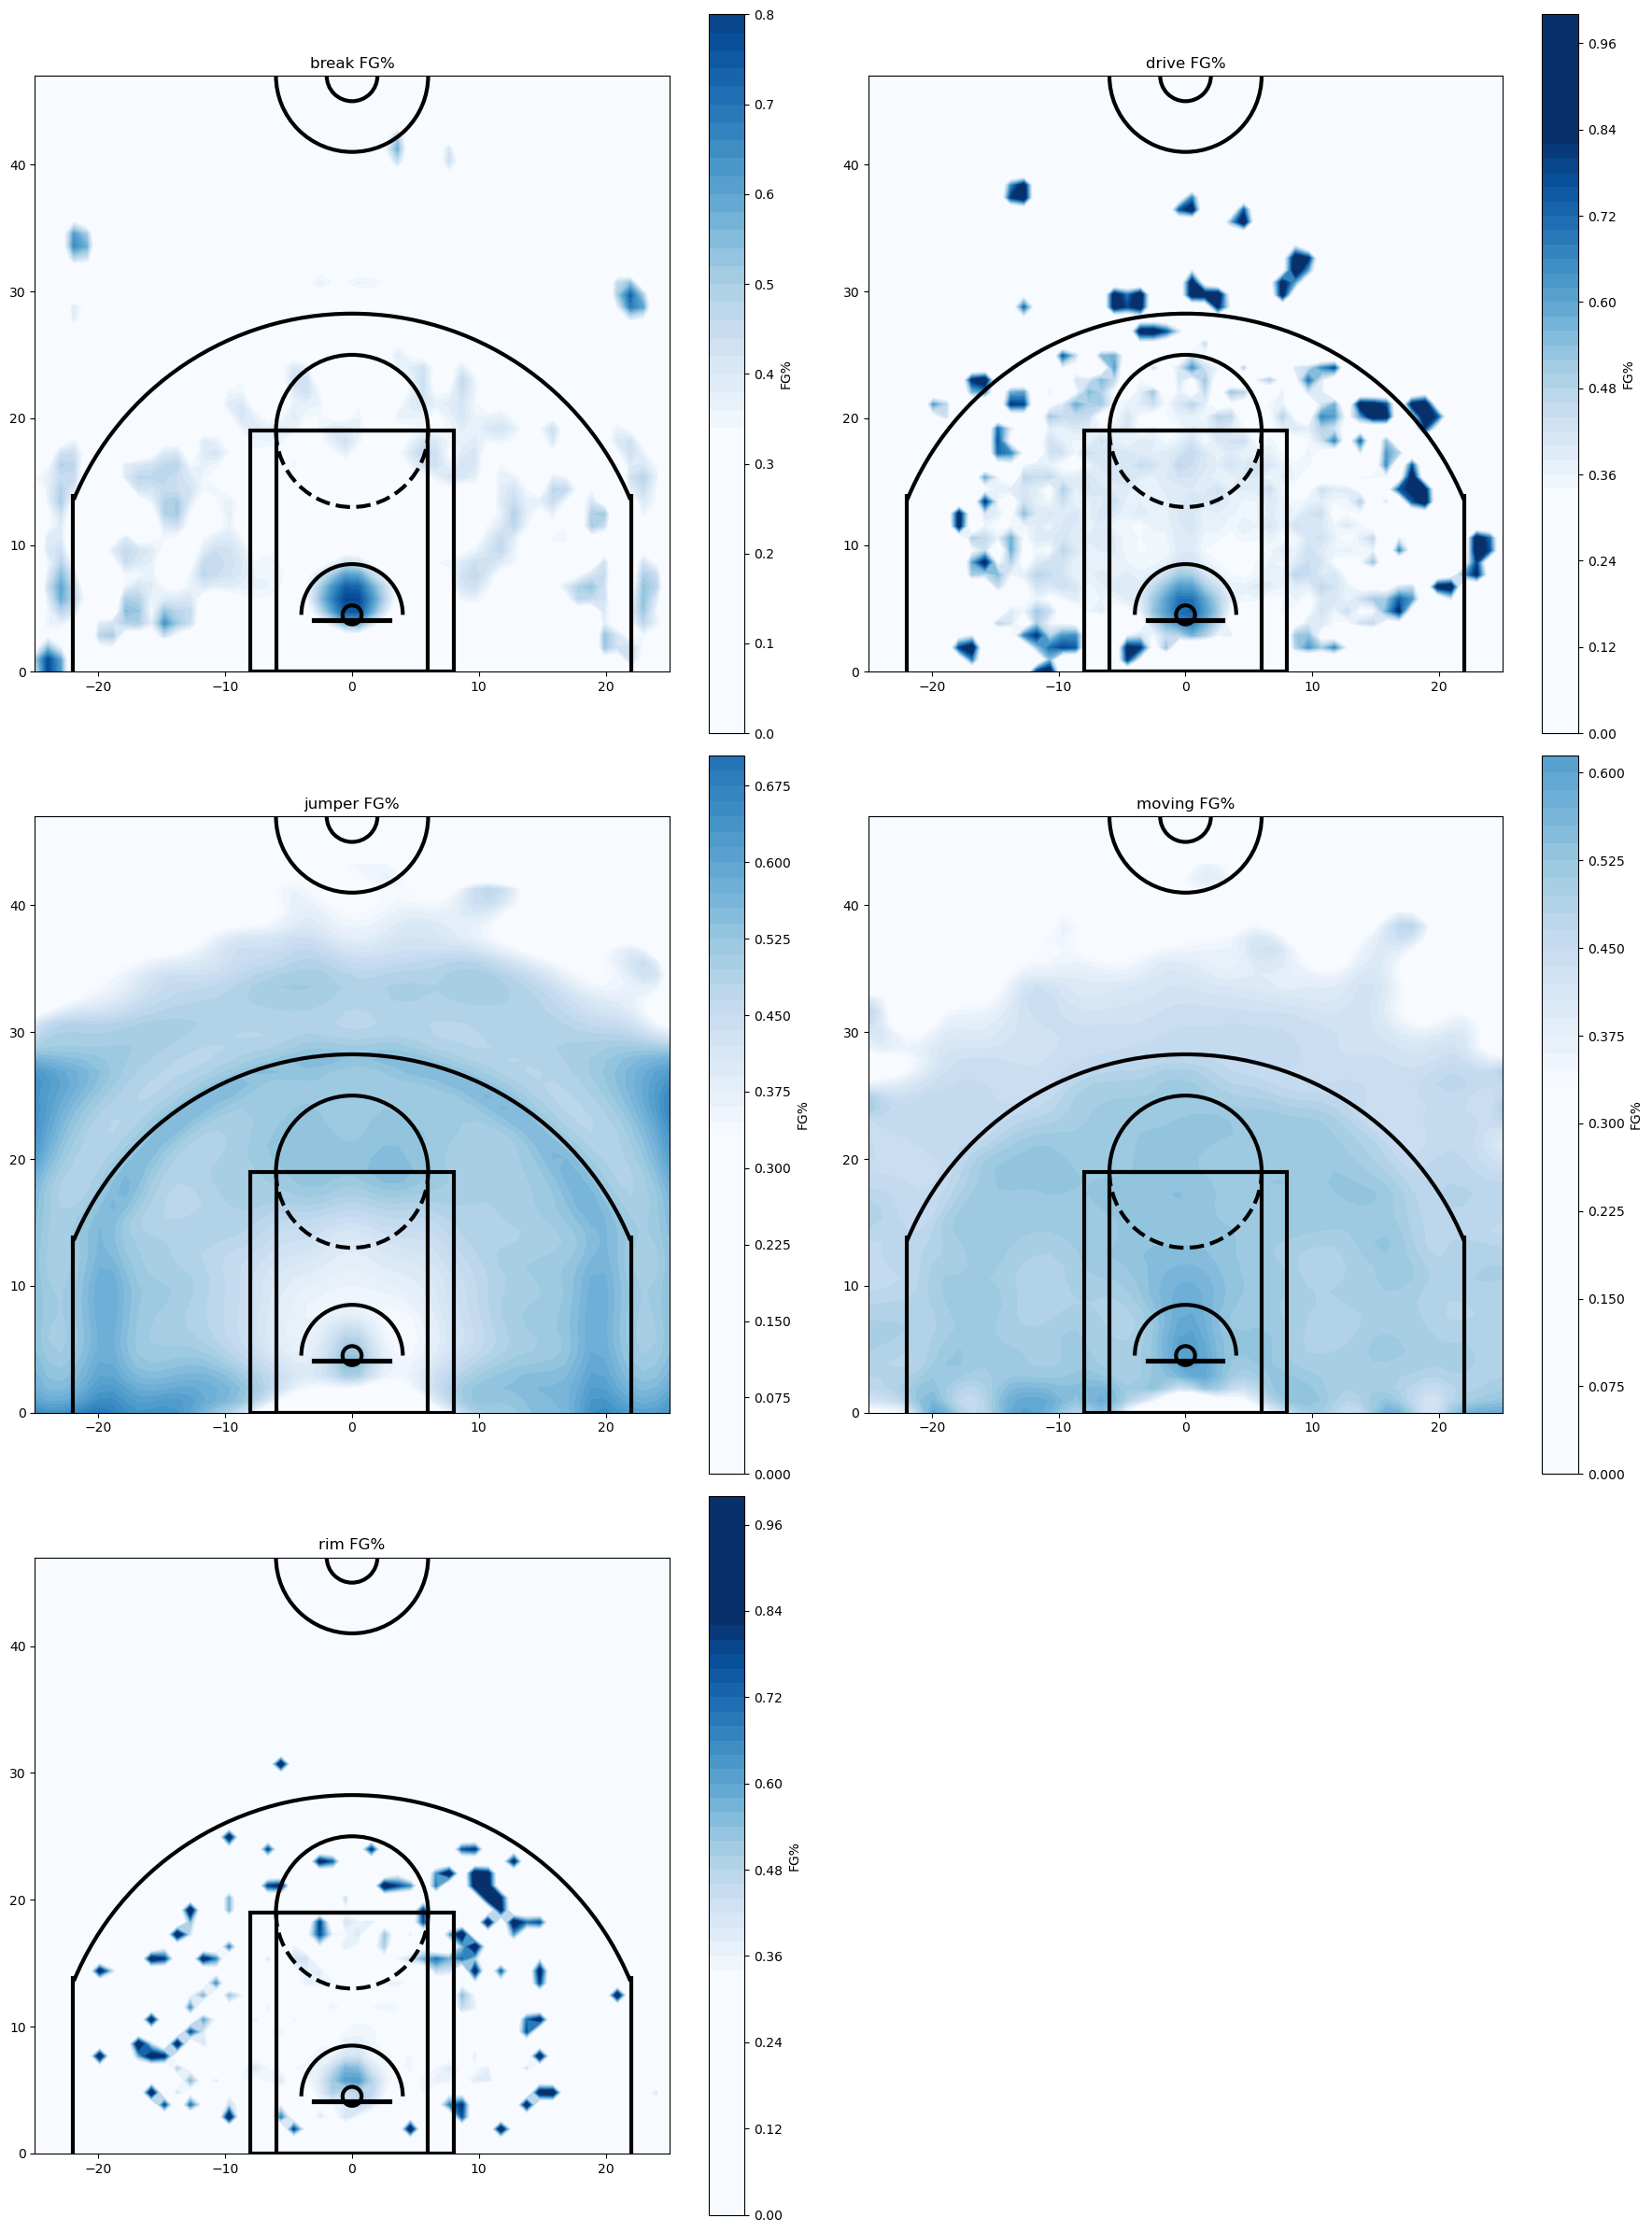

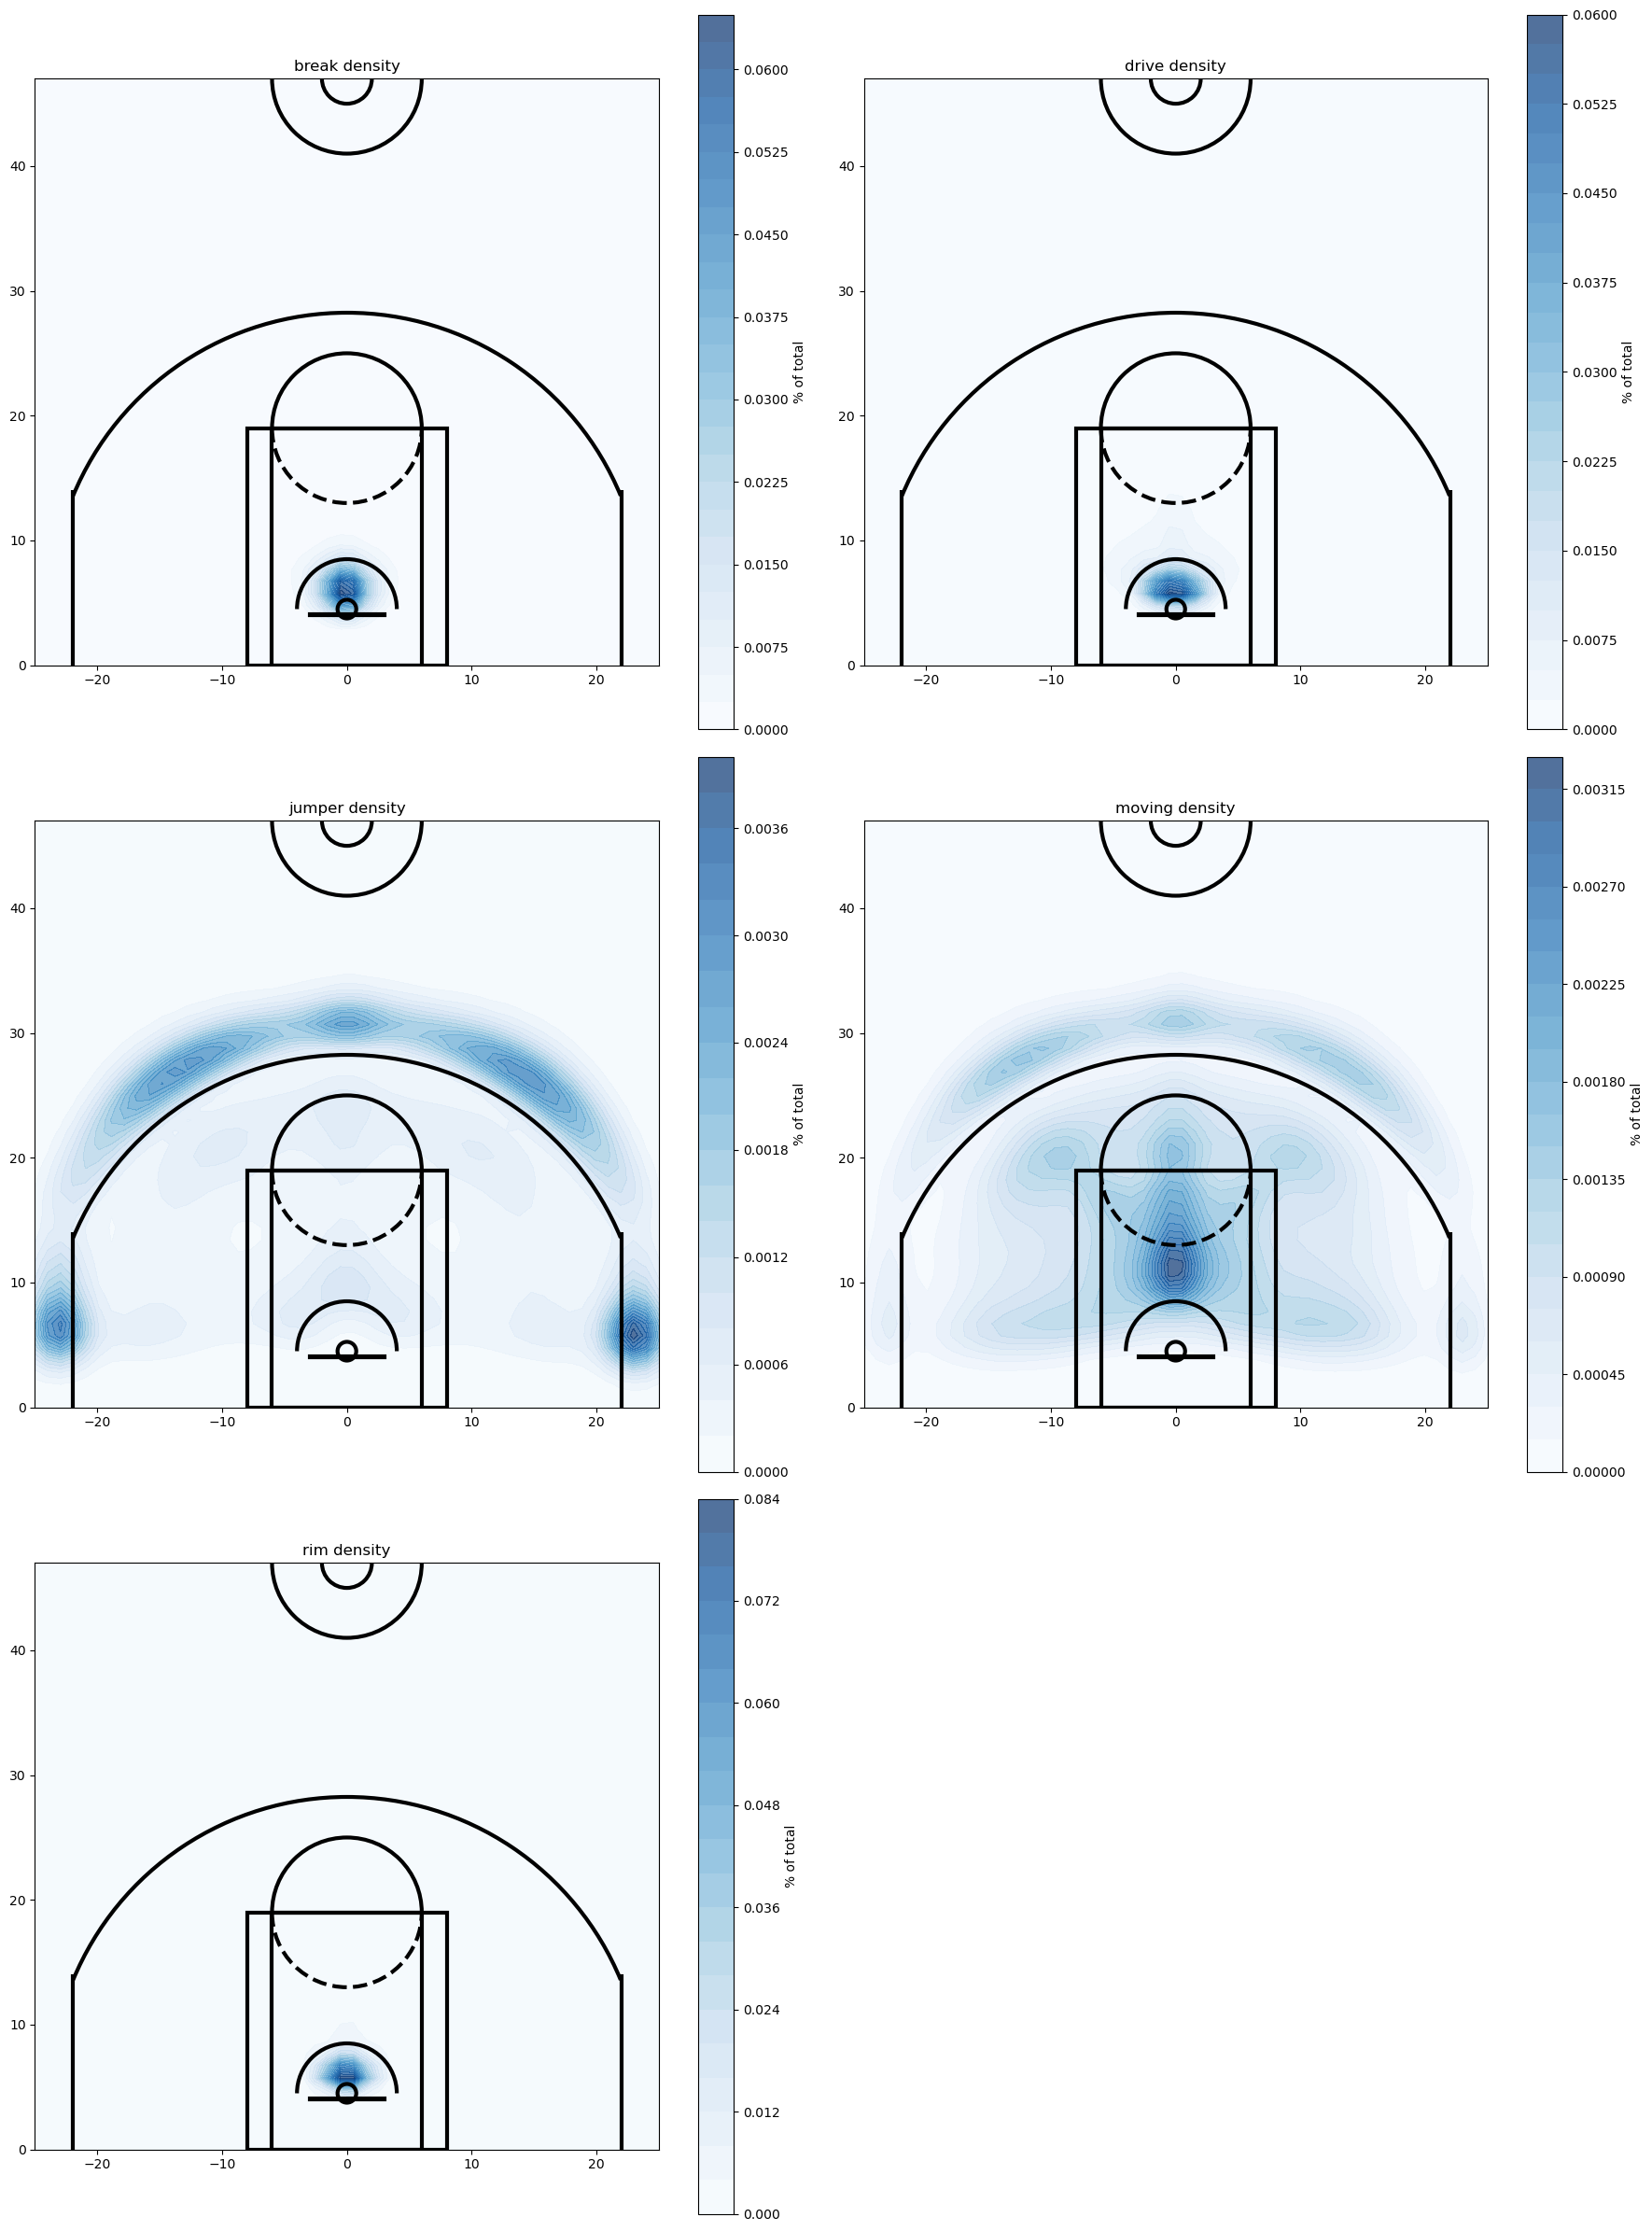

In [6]:
def plot_action_pct():

    x = np.linspace(-25, 25, 50)
    y = np.linspace(0, 47, 50)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(3, 2, figsize=(18, 24))
    axes = axes.flatten()

    for i , (action_group,values) in enumerate(shot_pcts.items()):
        ax = axes[i]
        shotpct = values['shotpct']

        contour = ax.contourf(
            X, Y, shotpct, levels=50, cmap='Blues', alpha=1,
            vmin=.33, vmax=.83
        )
        draw_court(ax=ax,color='black',lw=3)
        fig.colorbar(contour,ax=ax, label='FG%')
        ax.set_title(f'{action_group} FG%')
        ax.set_aspect('equal',adjustable='box')

    for i in range(len(shot_pcts),len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

def plot_action_density():

    x = np.linspace(-25, 25, 50)
    y = np.linspace(0, 47, 50)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(3, 2, figsize=(18, 24))
    axes = axes.flatten()

    for i , (action_group,values) in enumerate(shot_pcts.items()):
        ax = axes[i]
        density = values['density']

        contour = ax.contourf(
            X, Y, density, levels=25, cmap='Blues', alpha=.7
        )
        draw_court(ax=ax,color='black',lw=3)
        fig.colorbar(contour,ax=ax, label='% of total')
        ax.set_title(f'{action_group} density')
        ax.set_aspect('equal',adjustable='box')

    for i in range(len(shot_pcts),len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

plot_action_pct()
plot_action_density()



In [7]:
#getting list of elig player years
filtered_data['Player_Year'] = filtered_data['PLAYER_ID'].astype(str) + '_' + filtered_data['SEASON_1'].astype(str)
filtered_players_data = filtered_data[filtered_data['Player_Year'].isin(filtered_data.groupby('Player_Year').size()[lambda x: x >= min_shots].index)]

#one hot encoding Actions
encoder = OneHotEncoder(sparse_output=False)
actiongroup_encoded = encoder.fit_transform(filtered_players_data[['ActionGroup']])
features = np.hstack((
    np.abs(filtered_players_data[['LOC_X']].values),
    filtered_players_data[['LOC_Y']].values,
    actiongroup_encoded
))

#aggregating data for clustering
location_stats = filtered_players_data.groupby('Player_Year')[['LOC_X', 'LOC_Y']].agg(['mean', 'std']).reset_index()
location_stats.columns = ['Player_Year', 'LOC_X_mean', 'LOC_X_std', 'LOC_Y_mean', 'LOC_Y_std']
actiongroup_dist = filtered_players_data.groupby(['Player_Year', 'ActionGroup']).size().unstack(fill_value=0)
actiongroup_dist = actiongroup_dist.div(actiongroup_dist.sum(axis=1), axis=0).reset_index()
player_season_features = location_stats.merge(actiongroup_dist, on='Player_Year')
player_season_features = player_season_features.merge(filtered_players_data[['Player_Year', 'PLAYER_NAME']].drop_duplicates(), on='Player_Year')
features = player_season_features.drop(columns=['Player_Year', 'PLAYER_NAME']).values

#BIC analysis to determine optimal cluster amount, then GMM prediction for cluster labels
bic_scores = []
gmm_models = []
for n_clusters in range(6, 10):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', reg_covar=1e-1, random_state=0)
    gmm.fit(features)
    bic_scores.append(gmm.bic(features))
    gmm_models.append(gmm)

optimal_clusters = np.argmin(bic_scores) + 6
best_gmm = gmm_models[np.argmin(bic_scores)]
player_season_features['Cluster'] = best_gmm.predict(features)
filtered_players_data = filtered_players_data.merge(player_season_features[['Player_Year', 'Cluster']], on='Player_Year')

#creating bins, calculating percentages of each bin with binned_statistic_2d
x_edges = np.linspace(-25, 25, int(50/grid_size) + 1)
y_edges = np.linspace(0, 47, int(47/grid_size) + 1)
percentages = []
for cluster_id in range(optimal_clusters):
    cluster_data = filtered_players_data[filtered_players_data['Cluster'] == cluster_id]
    made_shots, _, _, _ = binned_statistic_2d(cluster_data['LOC_X'], cluster_data['LOC_Y'], cluster_data['SHOT_MADE'], statistic='sum', bins=[x_edges, y_edges])
    total_shots, _, _, _ = binned_statistic_2d(cluster_data['LOC_X'], cluster_data['LOC_Y'], cluster_data['SHOT_MADE'], statistic='count', bins=[x_edges, y_edges])
    shotpct = np.divide(made_shots, total_shots, out=np.zeros_like(made_shots), where=total_shots != 0)
    percentages.append(shotpct)

#calculate average % from each range across the league, and calculate above average
total_FGM = np.sum([p * t for p, t in zip(percentages, [np.histogram2d(filtered_players_data[filtered_players_data['Cluster'] == i]['LOC_X'], filtered_players_data[filtered_players_data['Cluster'] == i]['LOC_Y'], bins=[x_edges, y_edges])[0] for i in range(optimal_clusters)])], axis=0)
total_FGA = np.sum([np.histogram2d(filtered_players_data[filtered_players_data['Cluster'] == i]['LOC_X'], filtered_players_data[filtered_players_data['Cluster'] == i]['LOC_Y'], bins=[x_edges, y_edges])[0] for i in range(optimal_clusters)], axis=0)
tot_avg_pcts = np.divide(total_FGM, total_FGA, out=np.zeros_like(total_FGM), where=total_FGA != 0)
pct_above_avg = [p - tot_avg_pcts for p in percentages]

#distribution of KDE
kde_results_attempts = {i: gaussian_kde(filtered_players_data[filtered_players_data['Cluster'] == i][['LOC_X', 'LOC_Y']].T) for i in range(optimal_clusters)}
z_min_attempts = float('inf')
z_max_attempts = -float('inf')
for i in range(optimal_clusters):
    kde = kde_results_attempts[i]
    X, Y = np.meshgrid(
        np.linspace(filtered_players_data['LOC_X'].min(), filtered_players_data['LOC_X'].max(), 100),
        np.linspace(filtered_players_data['LOC_Y'].min(), 47, 47)
    )
    Z = kde(np.c_[X.ravel(), Y.ravel()].T).reshape(X.shape)
    z_min_attempts = min(z_min_attempts, Z.min())
    z_max_attempts = max(z_max_attempts, Z.max())





C:\Users\kfw32\AppData\Local\Temp\ipykernel_18760\2780783294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Player_Year'] = filtered_data['PLAYER_ID'].astype(str) + '_' + filtered_data['SEASON_1'].astype(str)
C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_

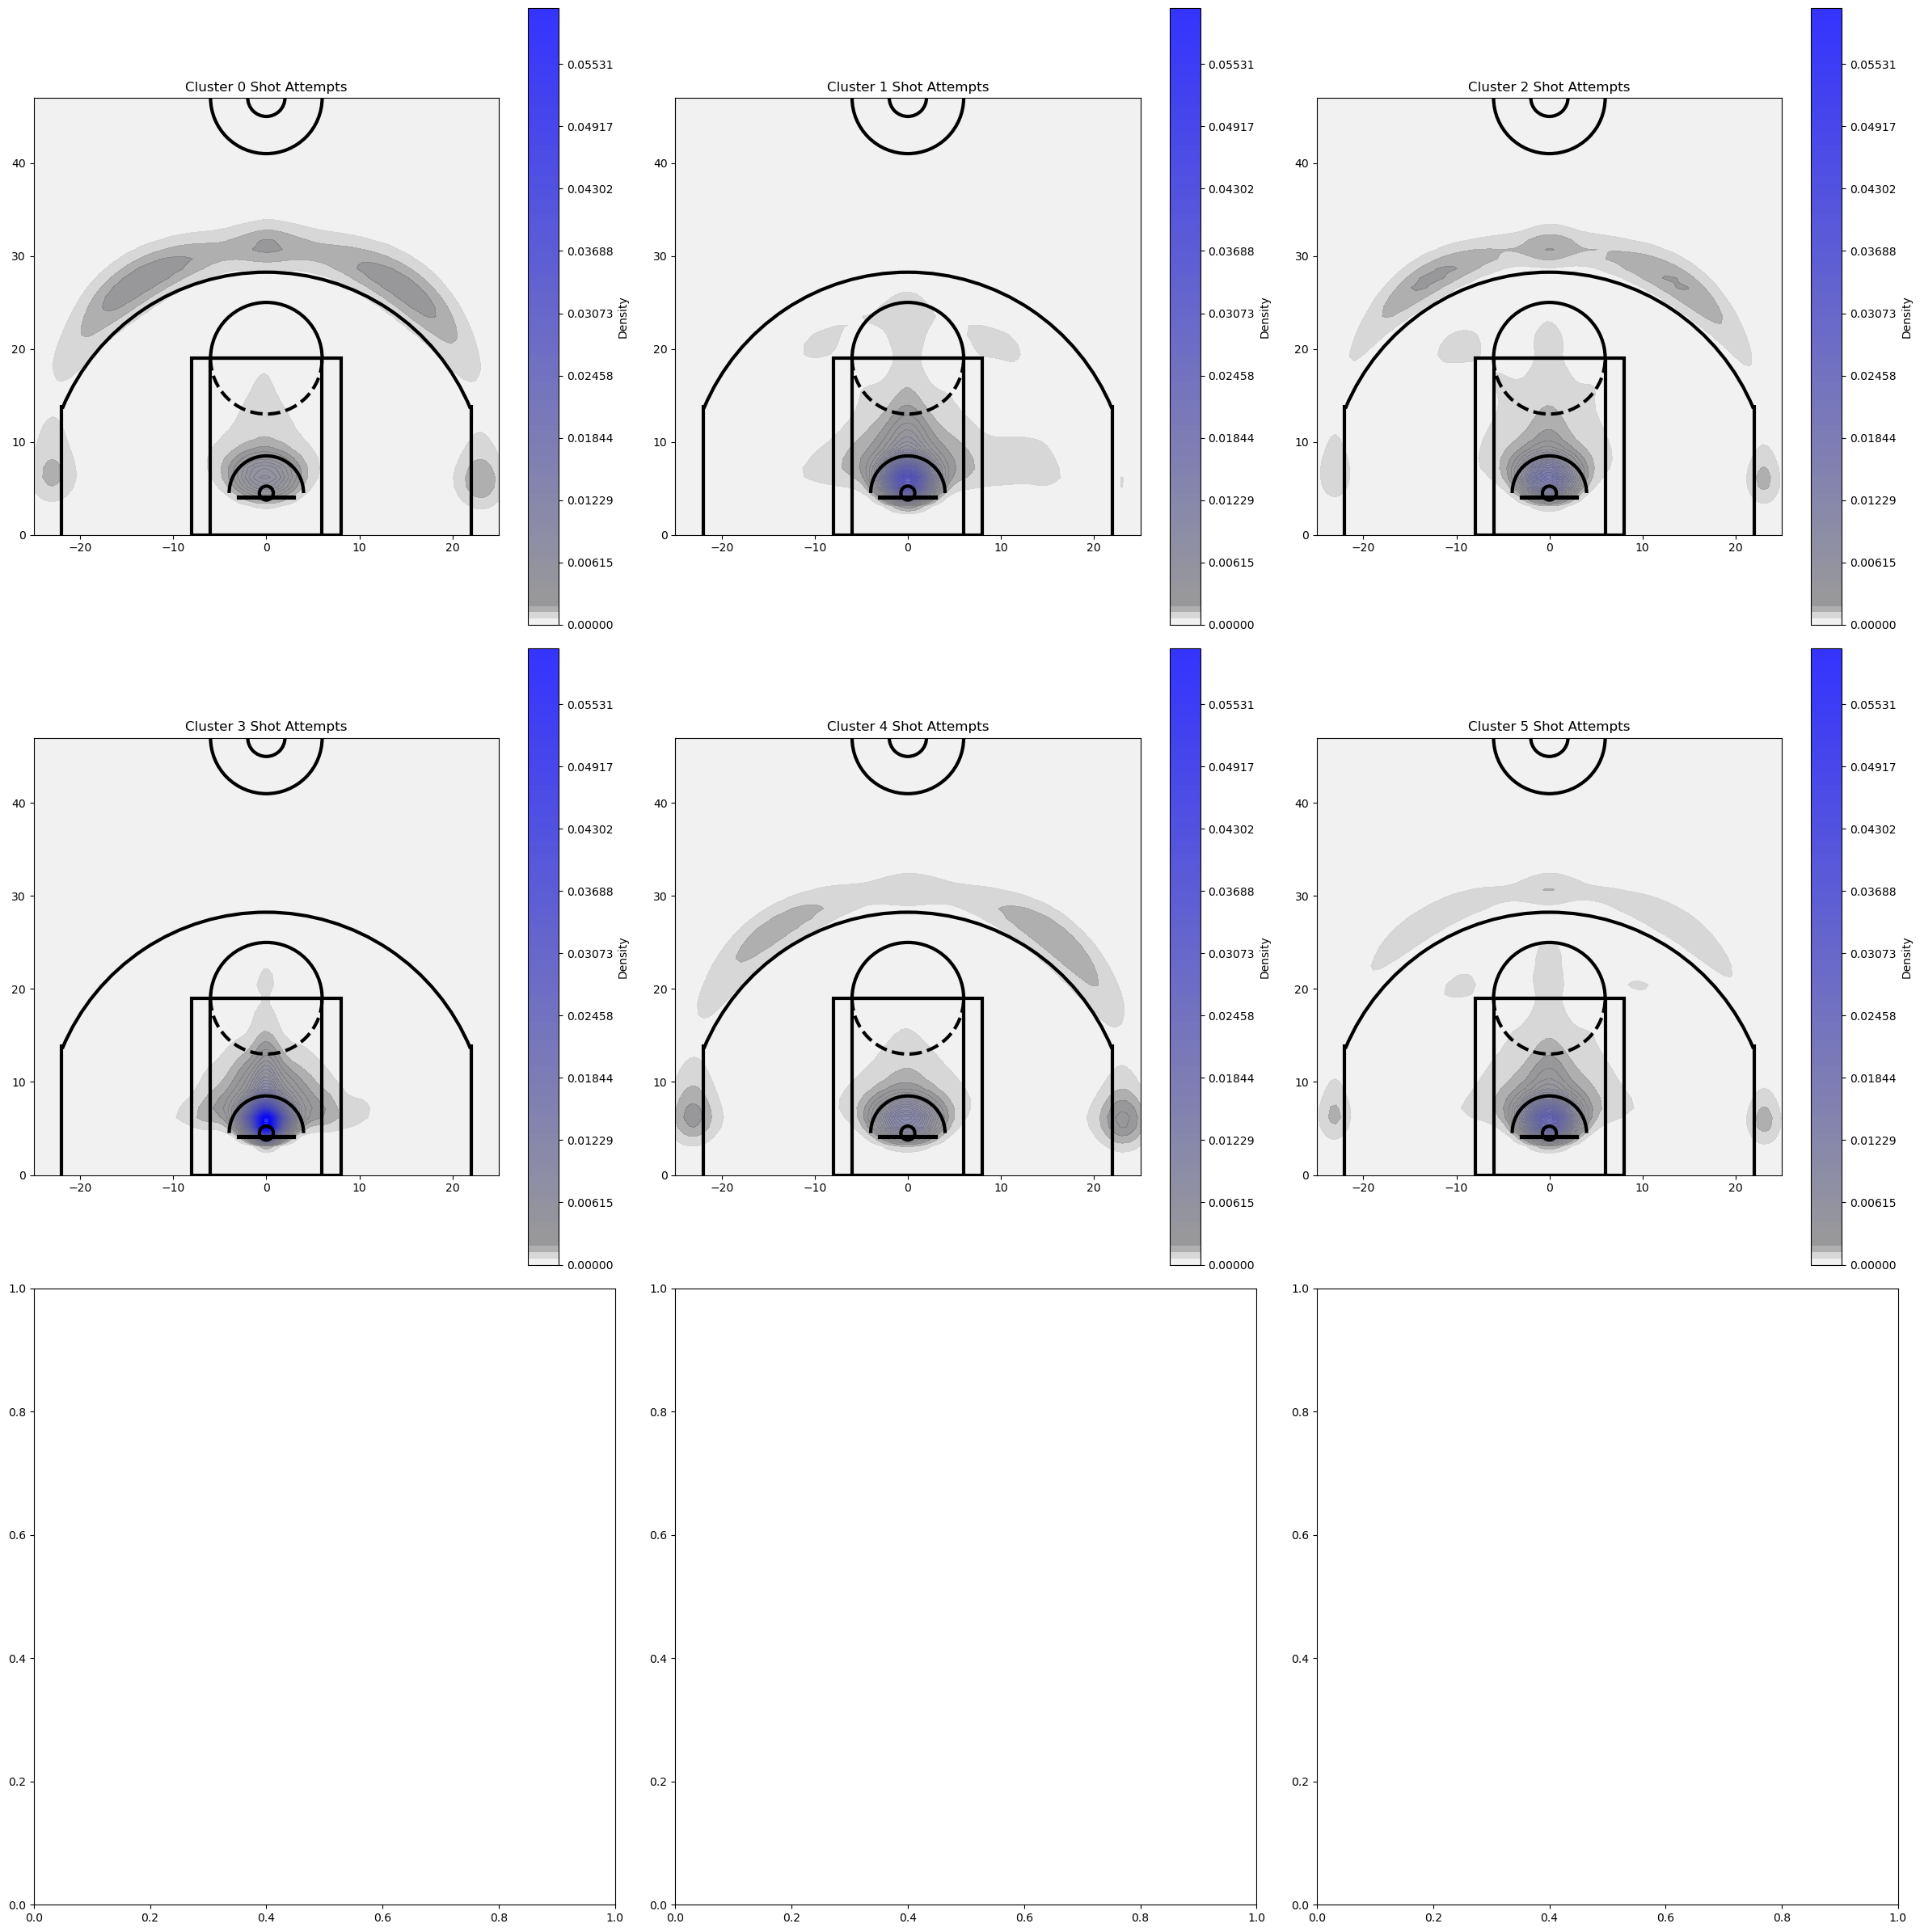

In [8]:
def shot_attempt_heatmap():
    colors = [(0.0, 'white'), (0.03, 'gray'), (1.0, 'blue')]
    cmap = LinearSegmentedColormap.from_list('three_tiered', colors)
    fig, axes = plt.subplots(3, 3, figsize=(24, 24))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:optimal_clusters]):
        kde = kde_results_attempts[i]
        X, Y = np.meshgrid(
            np.linspace(filtered_players_data['LOC_X'].min(), filtered_players_data['LOC_X'].max(), 100),
            np.linspace(filtered_players_data['LOC_Y'].min(), 47, 47)
        )
        Z = kde(np.c_[X.ravel(), Y.ravel()].T).reshape(X.shape)
        
        contour = ax.contourf(X, Y, Z, levels=np.linspace(z_min_attempts, z_max_attempts, 100), cmap=cmap, alpha=0.8)
        draw_court(ax=ax, color='black', lw=3)
        ax.set_title(f'Cluster {i} Shot Attempts')
        ax.set_aspect('equal', adjustable='box')
        fig.colorbar(contour, ax=ax, label='Density')
    plt.tight_layout()
    plt.show()

shot_attempt_heatmap()


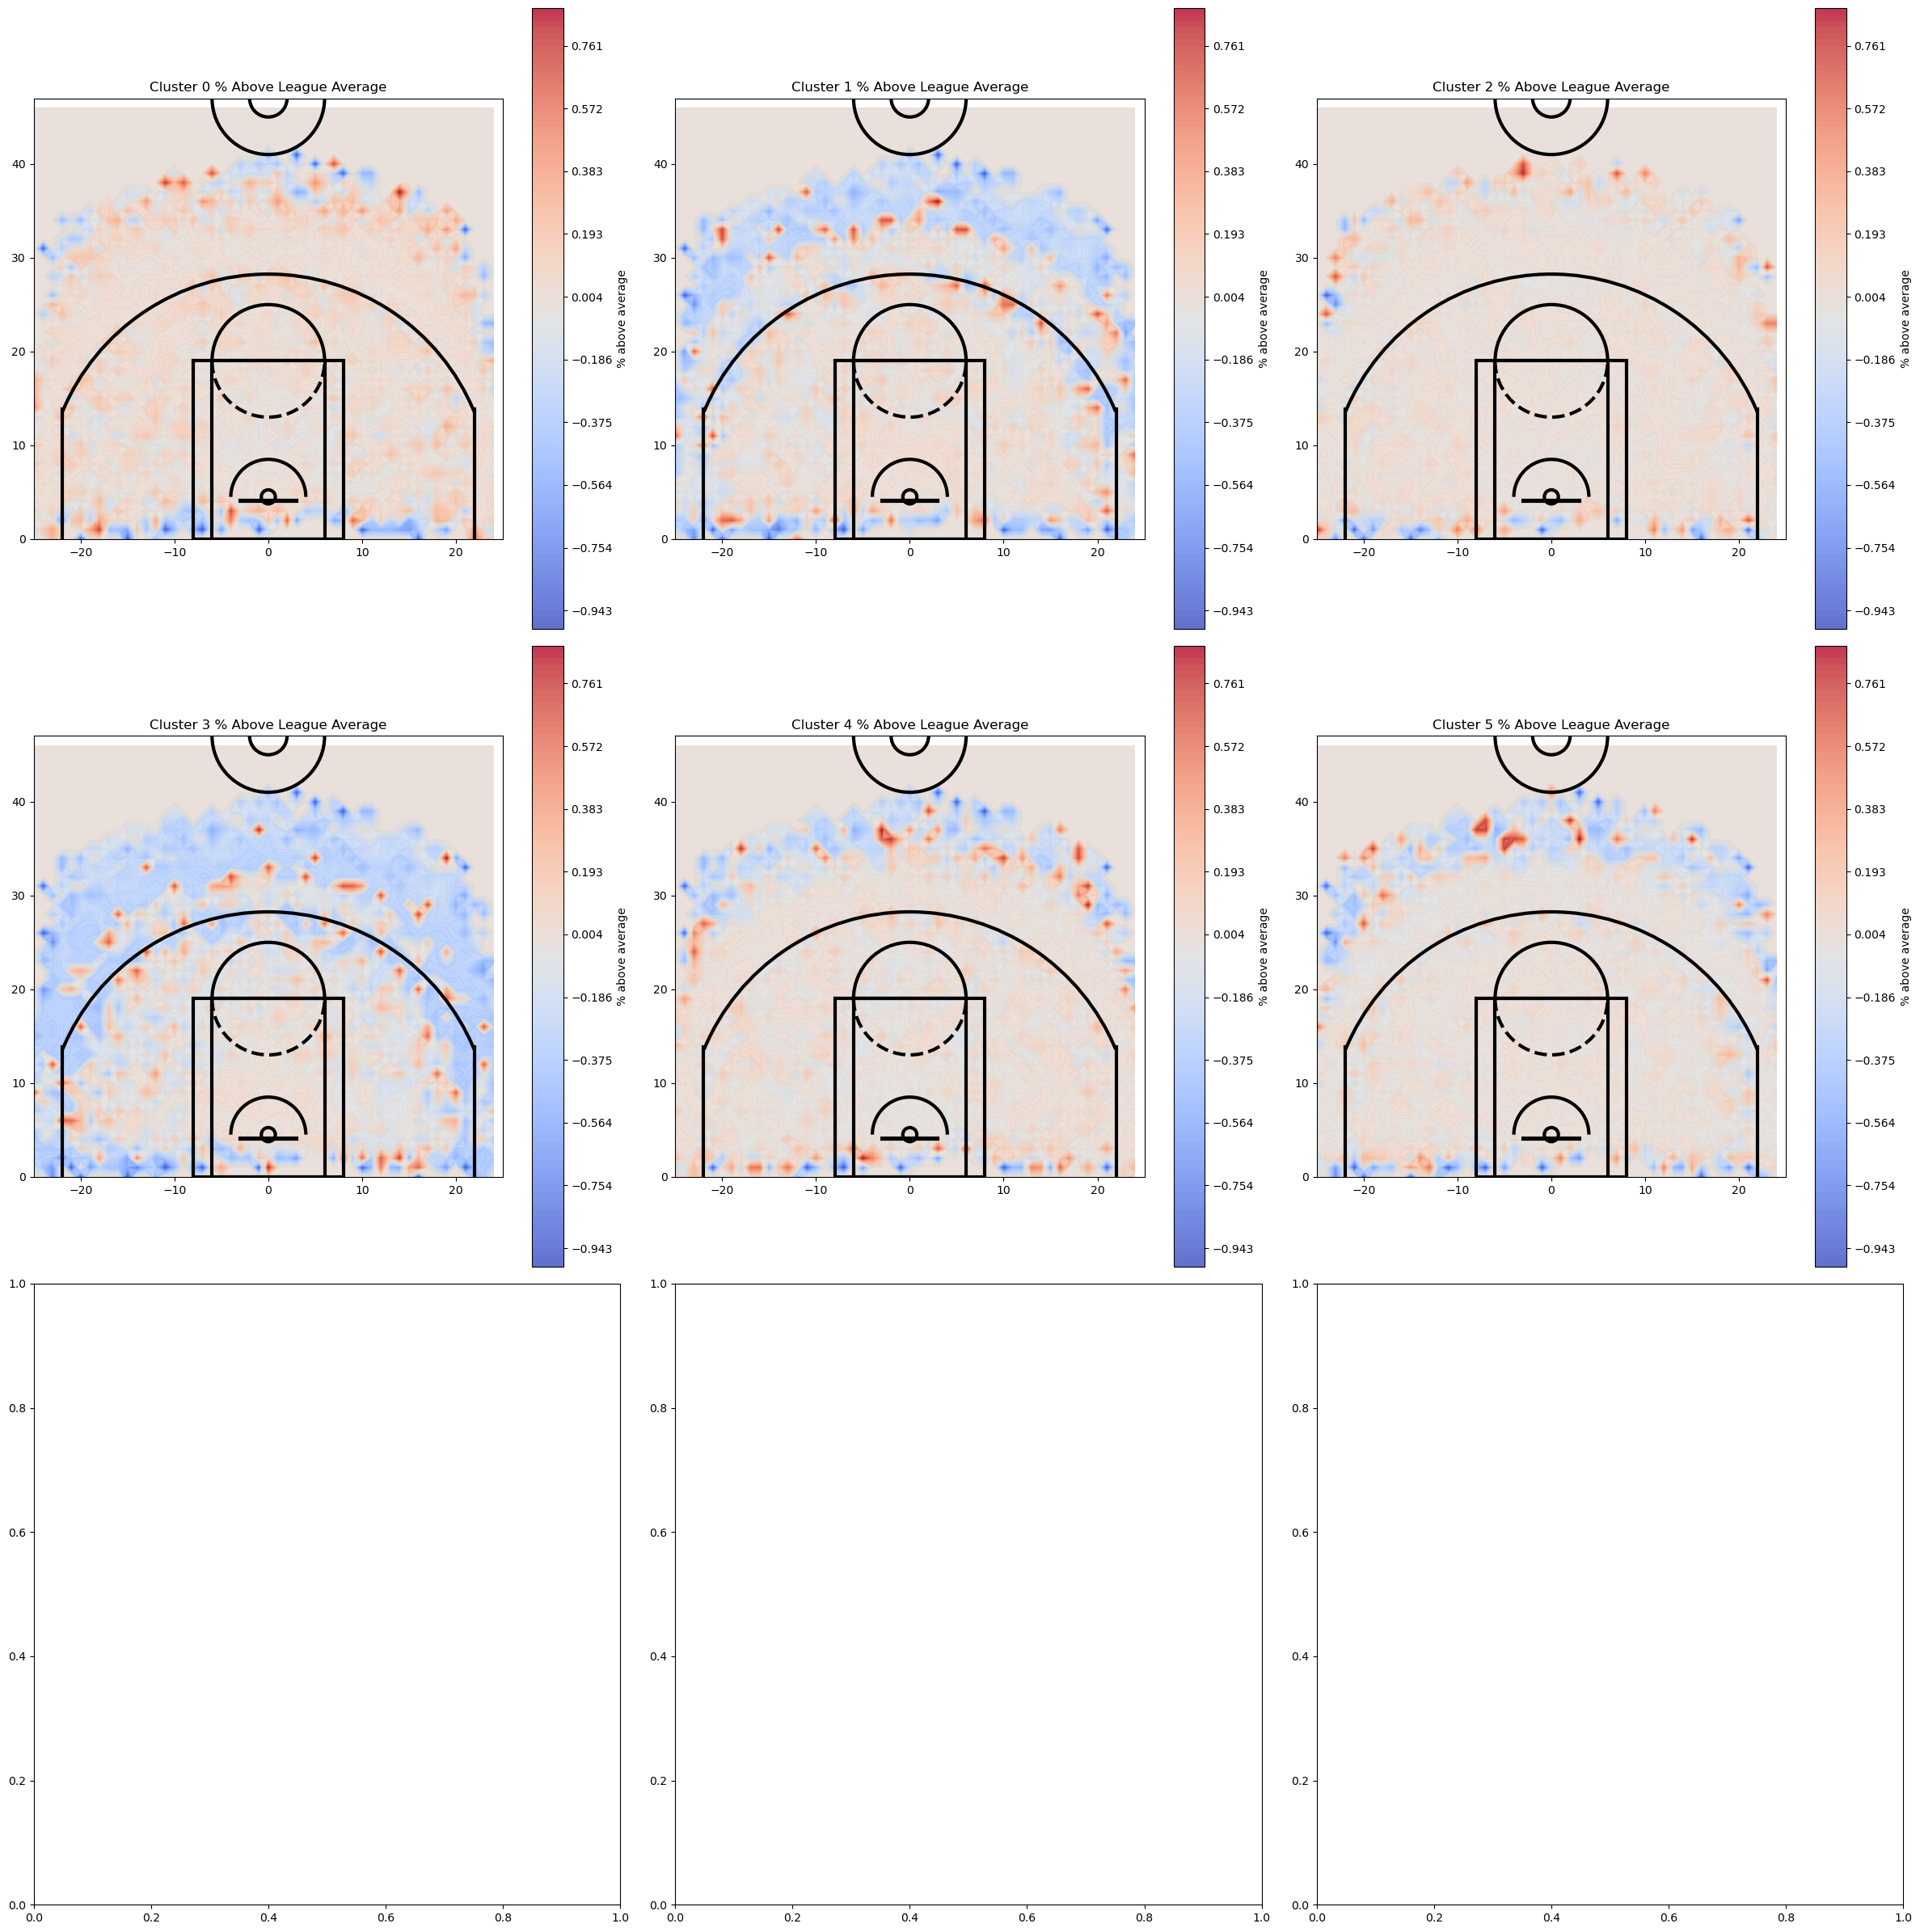

In [9]:

def shot_pct_heatmap():
    fig, axes = plt.subplots(3, 3, figsize=(24, 24))
    axes = axes.flatten()
    z_min_percentage = np.min([np.min(p) for p in pct_above_avg])
    z_max_percentage = np.max([np.max(p) for p in pct_above_avg])

    for i, ax in enumerate(axes[:optimal_clusters]):
        X, Y = np.meshgrid(x_edges[:-1], y_edges[:-1])
        Z = pct_above_avg[i].T
        contour = ax.contourf(X, Y, Z, levels=np.linspace(z_min_percentage, z_max_percentage, 100), cmap='coolwarm', alpha=0.8)
        draw_court(ax=ax,color='black',lw=3)
        ax.set_title(f'Cluster {i} % Above League Average')
        ax.set_aspect('equal', adjustable='box')
        fig.colorbar(contour, ax=ax, label='% above average')
    plt.tight_layout()
    plt.show()
    
shot_pct_heatmap()

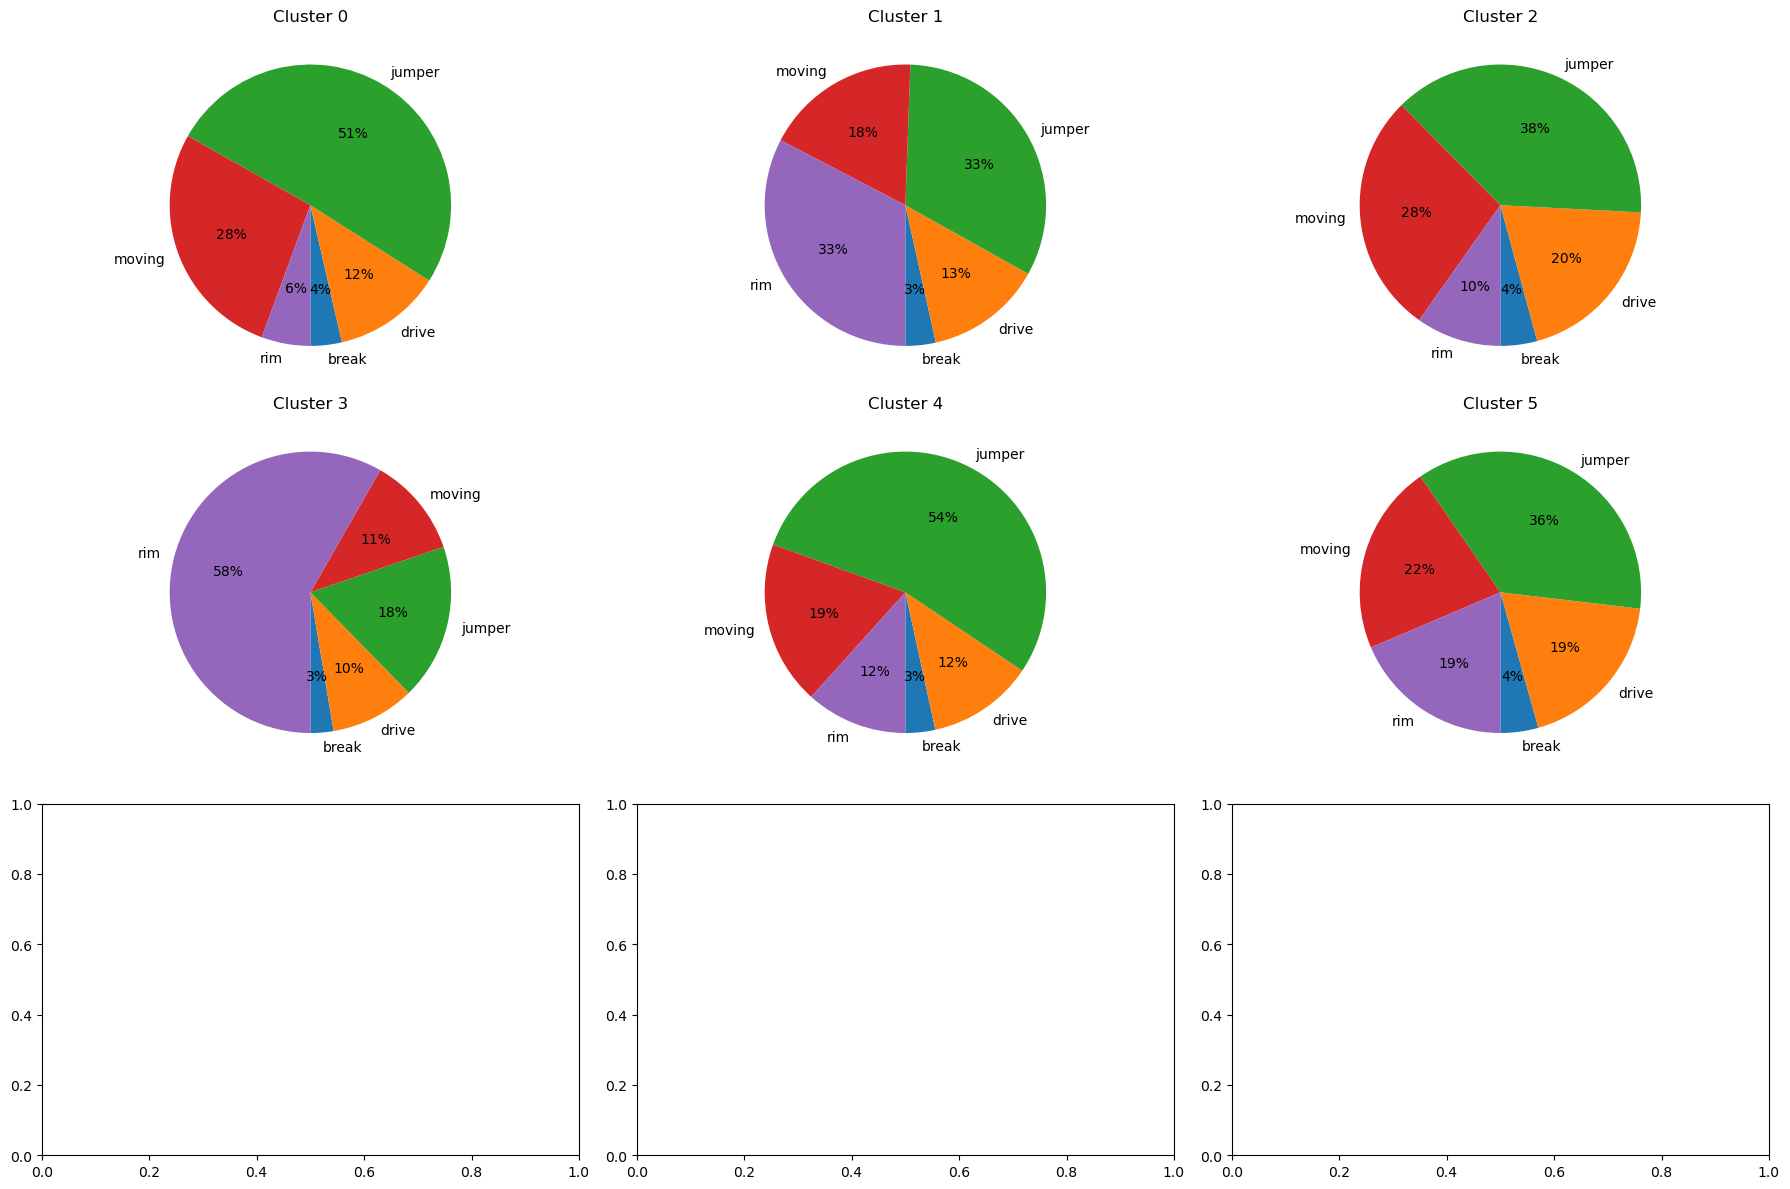

In [10]:
#actions
cluster_insights = {}
actiongroup_dominance = filtered_players_data.groupby(['Cluster', 'ActionGroup']).size().unstack(fill_value=0)
actiongroup_dominance = actiongroup_dominance.div(actiongroup_dominance.sum(axis=1), axis=0)
for cluster_id in range(optimal_clusters):
    cluster_data = filtered_players_data[filtered_players_data['Cluster'] == cluster_id]
    # high_percentage_zones = cluster_data.groupby(['LOC_X', 'LOC_Y']).size().nlargest(5).index.tolist()
    # low_percentage_zones = cluster_data.groupby(['LOC_X', 'LOC_Y']).size().nsmallest(5).index.tolist()
    # insights = {
    #     'High Percentage Zones': high_percentage_zones,
    #     'Low Percentage Zones': low_percentage_zones
    # }
    # cluster_insights[cluster_id] = insights

def action_by_cluster():
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, ax in enumerate(axes[:optimal_clusters]):
        cluster_data = actiongroup_dominance.loc[i]
        ax.pie(cluster_data, labels=cluster_data.index, autopct='%1.f%%', startangle=270)
        ax.set_title(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

action_by_cluster()

C:\Users\kfw32\AppData\Local\Temp\ipykernel_18760\2505682444.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('nipy_spectral', len(cluster_counts))


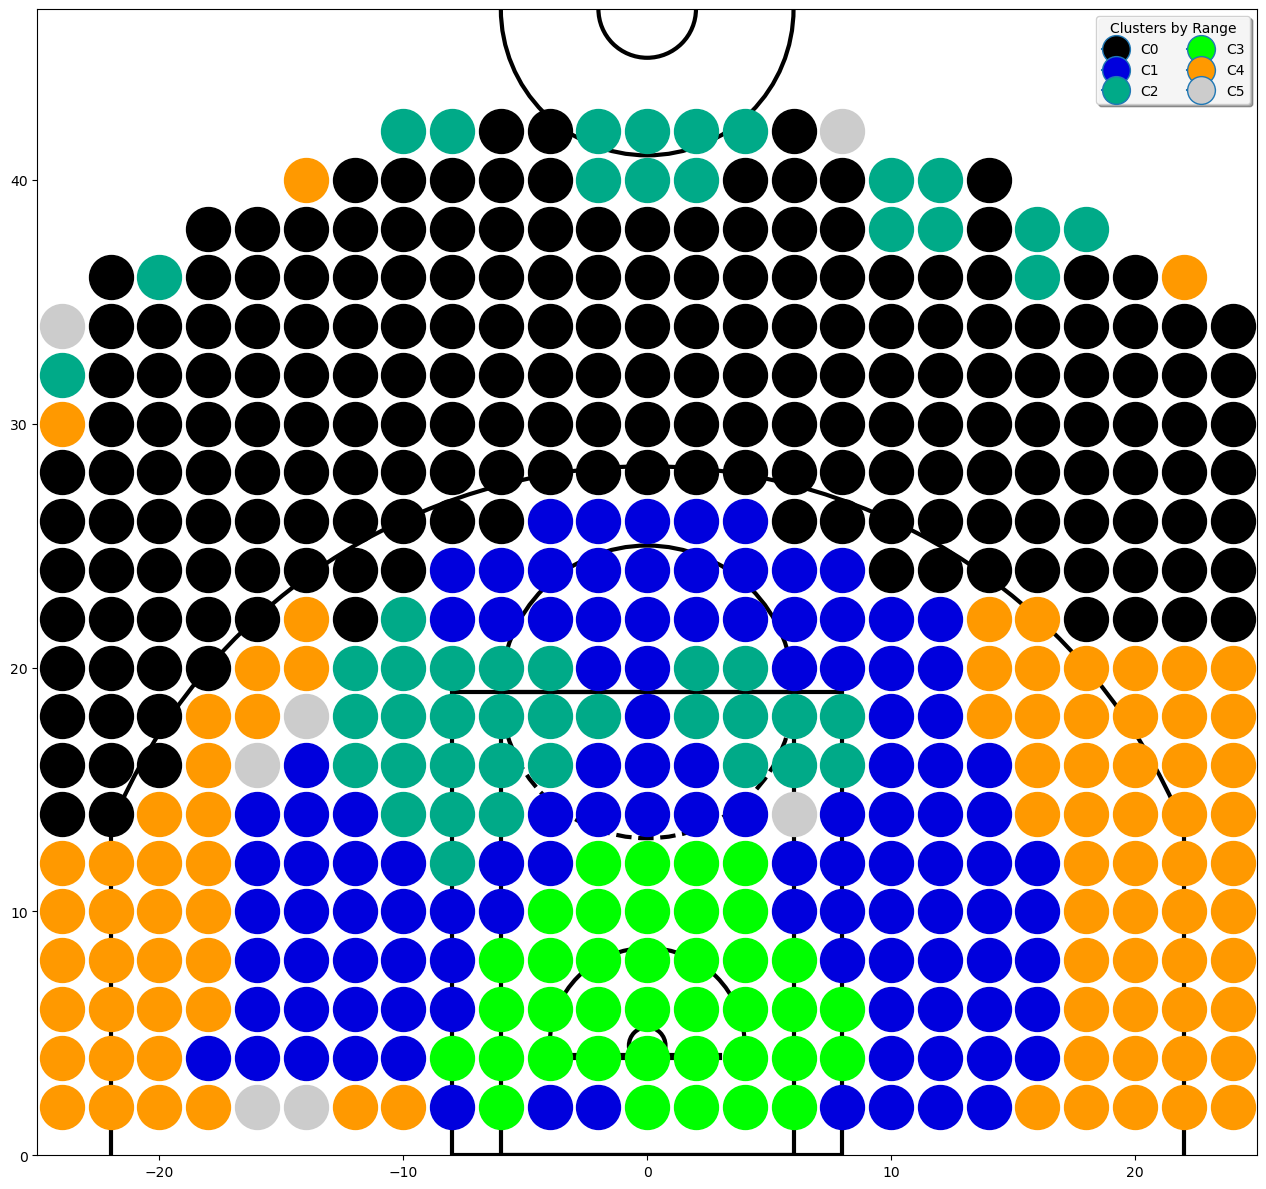

In [11]:
cluster_counts = pd.DataFrame(filtered_players_data['Cluster'].value_counts()).sort_index().reset_index()
xvals = sorted(set(np.arange(0,25,adv_grid_size).tolist() + np.arange(0,-25,-adv_grid_size).tolist()))
yvals = np.arange(adv_grid_size,47,adv_grid_size).tolist()

shot_array = np.empty((51, 48), dtype=object)
cluster_shot_array = np.empty((51, 48), dtype=object)

shot_array_filter_df = filtered_players_data[['LOC_X','LOC_Y','ActionGroup','Cluster']]

colormap = plt.cm.get_cmap('nipy_spectral', len(cluster_counts))

def dominant_cluster(cell_df, cluster_counts):
    cell_cluster_counts = cell_df['Cluster'].value_counts()
    cell_cluster_pct = (cell_cluster_counts / cluster_counts.set_index('Cluster')['count'])*100
    return cell_cluster_pct.idxmax()




for x in xvals:
    if x>0: xincl='right'
    elif x<0: xincl='left'
    else: xincl='both'
    for y in yvals:
        if y==adv_grid_size: yincl='both'
        else: yincl='right'
        cell_df = shot_array_filter_df[(shot_array_filter_df['LOC_X'].between(x-adv_grid_size,x+adv_grid_size,inclusive=xincl)) & (shot_array_filter_df['LOC_Y'].between(y-adv_grid_size,y+adv_grid_size,inclusive=yincl))]
        if not cell_df.empty:
            shot_array[x,y] = cell_df
            cluster_shot_array[x,y] = dominant_cluster(cell_df,cluster_counts)
            #progress(f'{x},{y},  {cluster_shot_array[x,y]}')

def plot_shot_clusters(cluster_shot_array):
    fig, ax = plt.subplots(figsize=(15,12))
    draw_court(ax=ax,color='black',lw=3)
    for i in xvals:
        for j in yvals:
            if cluster_shot_array[i,j] is not None:
                cluster = cluster_shot_array[i,j]
                ax.scatter(i,j,s=1000, c=[colormap(cluster)], marker='o')
                ax.set_aspect('equal', adjustable='box')
    handles = [plt.Line2D([0],[0], marker='o', markerfacecolor=colormap(cluster),markersize=20, label=f'C{cluster}') for cluster in cluster_counts['Cluster']]
    ax.legend(handles=handles, title='Clusters by Range', loc='upper right', ncol=2, frameon=True, framealpha=0.9, fontsize='medium', fancybox=True, shadow=True)
            
    plt.tight_layout()
    #plt.legend()
    plt.show()

plot_shot_clusters(cluster_shot_array)

In [12]:
cluster_data.groupby(['ActionGroup'])


In [13]:
cluster_data

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ActionGroup,Player_Year,Cluster
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,2022-10-19,22200004,IND,WAS,Made Shot,1,jump shot,3PT Field Goal,Left Corner 3,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20,jumper,203078_2023,5
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,2022-10-19,22200004,IND,WAS,Made Shot,1,cutting dunk shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5,rim,1630166_2023,5
11,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,2022-10-19,22200004,IND,WAS,Missed Shot,0,driving finger roll layup shot,2PT Field Goal,Mid-Range,Right Side,R,8-16 ft.,-9.1,13.25,12,1,5,28,drive,203078_2023,5
12,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,2022-10-19,22200004,IND,WAS,Made Shot,1,tip layup shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.0,5.25,0,1,5,24,rim,203078_2023,5
13,2023,2022-23,1610612764,Washington Wizards,1629060,Rui Hachimura,F,PF,2022-10-19,22200004,IND,WAS,Missed Shot,0,step back jump shot,2PT Field Goal,In The Paint (Non-RA),Right Side,R,8-16 ft.,-8.0,17.85,14,1,4,38,moving,1629060_2023,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404336,2014,2013-14,1610612754,Indiana Pacers,202362,Lance Stephenson,G,SG,2013-10-29,21300001,IND,ORL,Made Shot,1,tip shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-1.5,5.65,1,1,8,40,rim,202362_2014,5
1404343,2014,2013-14,1610612748,Miami Heat,2544,LeBron James,F,PF,2013-10-29,21300002,MIA,CHI,Missed Shot,0,fadeaway jump shot,2PT Field Goal,Mid-Range,Right Side,R,8-16 ft.,-9.7,15.95,14,1,8,46,moving,2544_2014,5
1404346,2014,2013-14,1610612754,Indiana Pacers,202362,Lance Stephenson,G,SG,2013-10-29,21300001,IND,ORL,Missed Shot,0,jump shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-6.2,30.95,26,1,9,36,jumper,202362_2014,5
1404355,2014,2013-14,1610612748,Miami Heat,201596,Mario Chalmers,G,PG,2013-10-29,21300002,MIA,CHI,Missed Shot,0,jump shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-10.5,28.35,25,1,9,55,jumper,201596_2014,5


In [14]:
filtered_players_data

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,ActionGroup,Player_Year,Cluster
0,2023,2022-23,1610612764,Washington Wizards,203078,Bradley Beal,G,SG,2022-10-19,22200004,IND,WAS,Made Shot,1,jump shot,3PT Field Goal,Left Corner 3,Left Side,L,24+ ft.,23.4,12.95,24,1,11,20,jumper,203078_2023,5
1,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,2022-10-19,22200004,IND,WAS,Missed Shot,0,step back jump shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-0.4,31.45,26,1,10,52,moving,204001_2023,2
2,2023,2022-23,1610612764,Washington Wizards,1628420,Monte Morris,G,PG,2022-10-19,22200004,IND,WAS,Made Shot,1,running finger roll layup shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-1.3,5.25,1,1,10,39,break,1628420_2023,2
3,2023,2022-23,1610612764,Washington Wizards,204001,Kristaps Porzingis,C,C,2022-10-19,22200004,IND,WAS,Made Shot,1,cutting dunk shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.1,7.25,2,1,10,31,rim,204001_2023,2
4,2023,2022-23,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,2022-10-19,22200004,IND,WAS,Made Shot,1,cutting dunk shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,1.8,7.15,2,1,10,5,rim,1630166_2023,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404363,2014,2013-14,1610612753,Orlando Magic,201167,Arron Afflalo,G,SG,2013-10-29,21300001,IND,ORL,Missed Shot,0,jump shot,3PT Field Goal,Above the Break 3,Center,C,24+ ft.,-5.1,31.85,27,1,11,15,jumper,201167_2014,4
1404364,2014,2013-14,1610612748,Miami Heat,2548,Dwyane Wade,G,SG,2013-10-29,21300002,MIA,CHI,Missed Shot,0,jump shot,2PT Field Goal,Mid-Range,Right Side,R,16-24 ft.,-18.1,15.35,20,1,11,10,jumper,2548_2014,1
1404365,2014,2013-14,1610612754,Indiana Pacers,202331,Paul George,F,SF,2013-10-29,21300001,IND,ORL,Made Shot,1,pullup jump shot,2PT Field Goal,Mid-Range,Right Side Center,RC,16-24 ft.,-10.5,21.65,19,1,11,30,moving,202331_2014,2
1404366,2014,2013-14,1610612741,Chicago Bulls,202710,Jimmy Butler,G,SG,2013-10-29,21300002,MIA,CHI,Missed Shot,0,jump shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.4,21.65,21,1,11,17,jumper,202710_2014,4


In [15]:
player_season_features

,Player_Year,LOC_X_mean,LOC_X_std,LOC_Y_mean,LOC_Y_std,break,drive,jumper,moving,rim,PLAYER_NAME,Cluster
0,101107_2014,1.395010,13.068119,15.462284,9.083942,0.028791,0.034549,0.689060,0.078695,0.168906,Marvin Williams,4
1,101107_2016,1.732483,13.080229,15.473490,9.656364,0.006711,0.048322,0.672483,0.091275,0.181208,Marvin Williams,4
2,101107_2017,1.058037,12.459952,15.376458,9.693172,0.014225,0.069701,0.657183,0.075391,0.183499,Marvin Williams,4
3,101107_2018,2.213677,12.817961,15.945737,9.794756,0.007105,0.076377,0.595027,0.106572,0.214920,Marvin Williams,4
4,101107_2019,2.343692,13.836835,15.614462,9.493919,0.009231,0.084615,0.610769,0.124615,0.170769,Marvin Williams,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1706,2772_2018,-2.189522,15.863961,14.938598,9.434911,0.050847,0.140216,0.665639,0.061633,0.081664,Trevor Ariza,4
1707,2772_2019,-2.298367,14.365579,14.914490,9.160181,0.042177,0.190476,0.527891,0.123810,0.115646,Trevor Ariza,4
1708,951_2014,-1.280705,16.177540,13.970965,8.201618,0.011132,0.096475,0.745826,0.070501,0.076067,Ray Allen,4
1709,977_2015,-1.039888,11.601471,15.858989,8.208514,0.007022,0.049157,0.627809,0.217697,0.098315,Kobe Bryant,2


In [16]:
cluster_list_df = player_season_features[['Player_Year','Cluster','break','drive','jumper','moving','rim']]
cluster_list_df['Player'] = player_season_features['Player_Year'].apply(lambda x: x.split('_')[1]) + ' ' + player_season_features['PLAYER_NAME']

cluster_list_df.to_csv('cluster_list_df.csv')

C:\Users\kfw32\AppData\Local\Temp\ipykernel_18760\4232596013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_list_df['Player'] = player_season_features['Player_Year'].apply(lambda x: x.split('_')[1]) + ' ' + player_season_features['PLAYER_NAME']


In [17]:
cluster_counts

,Cluster,count
0,0,181830
1,1,99976
2,2,486530
3,3,97616
4,4,224200
5,5,314216


In [27]:
#------------------------------------
#validating data above with 2024 data

val_shot_data = shotdata[(shotdata['SEASON_1'] >= 2024) & (shotdata['SHOT_DISTANCE'] <= max_distance)]


#getting list of elig player years
val_shot_data['Player_Year'] = val_shot_data['PLAYER_ID'].astype(str) + '_' + val_shot_data['SEASON_1'].astype(str)
val_players_data = val_shot_data[val_shot_data['Player_Year'].isin(val_shot_data.groupby('Player_Year').size()[lambda x: x >= min_shots].index)]

#one hot encoding Actions
encoder = OneHotEncoder(sparse_output=False)
actiongroup_encoded = encoder.fit_transform(val_players_data[['ActionGroup']])
features = np.hstack((
    np.abs(val_players_data[['LOC_X']].values),
    val_players_data[['LOC_Y']].values,
    actiongroup_encoded
))

#aggregating data for clustering
location_stats = val_players_data.groupby('Player_Year')[['LOC_X', 'LOC_Y']].agg(['mean', 'std']).reset_index()
location_stats.columns = ['Player_Year', 'LOC_X_mean', 'LOC_X_std', 'LOC_Y_mean', 'LOC_Y_std']
actiongroup_dist = val_players_data.groupby(['Player_Year', 'ActionGroup']).size().unstack(fill_value=0)
actiongroup_dist = actiongroup_dist.div(actiongroup_dist.sum(axis=1), axis=0).reset_index()
player_season_features = location_stats.merge(actiongroup_dist, on='Player_Year')
player_season_features = player_season_features.merge(val_players_data[['Player_Year', 'PLAYER_NAME']].drop_duplicates(), on='Player_Year')
features = player_season_features.drop(columns=['Player_Year', 'PLAYER_NAME']).values

#BIC analysis to determine optimal cluster amount, then GMM prediction for cluster labels
# bic_scores = []
# gmm_models = []
# for n_clusters in range(6, 10):
#     gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', reg_covar=1e-1, random_state=0)
#     gmm.fit(features)
#     bic_scores.append(gmm.bic(features))
#     gmm_models.append(gmm)

# optimal_clusters = np.argmin(bic_scores) + 6
# best_gmm = gmm_models[np.argmin(bic_scores)]
cluster_probs = best_gmm.predict_proba(features)
cluster_probs_df = pd.DataFrame(cluster_probs, columns=[f'C{i}%' for i in range(cluster_probs.shape[1])])
player_season_features = pd.concat([player_season_features.reset_index(drop=True), cluster_probs_df], axis=1)
for col in [f'C{i}%' for i in range(cluster_probs.shape[1])]:
    player_season_features[col] = player_season_features[col].apply(lambda x: f"{x * 100:.1f}%")
val_cluster_output = player_season_features[['Player_Year','PLAYER_NAME','C0%','C1%','C2%','C3%','C4%','C5%']]
val_cluster_output['Cluster'] = np.argmax(cluster_probs, axis=1)
val_cluster_output

C:\Users\kfw32\AppData\Local\Temp\ipykernel_18760\939111944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_shot_data['Player_Year'] = val_shot_data['PLAYER_ID'].astype(str) + '_' + val_shot_data['SEASON_1'].astype(str)
C:\Users\kfw32\AppData\Local\Temp\ipykernel_18760\939111944.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_cluster_output['Cluster'] = np.argmax(cluster_probs, axis=1)


In [29]:
val_cluster_output.to_csv('val_cluster_output.csv')

In [31]:
val_cluster_input = pd.read_csv('val_cluster_input.csv')
val_cluster_input

,Unnamed: 0,Player_Year,PLAYER_NAME,C0%,C1%,C2%,C3%,C4%,C5%,Cluster
0,0,1626145_2024,Tyus Jones,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1,1,1626156_2024,D'Angelo Russell,0.0,NaN,2.0,NaN,NaN,NaN,NaN
2,2,1626157_2024,Karl-Anthony Towns,NaN,NaN,2.0,NaN,NaN,5.0,NaN
3,3,1626162_2024,Kelly Oubre Jr.,NaN,NaN,2.0,NaN,NaN,5.0,NaN
4,4,1626164_2024,Devin Booker,0.0,NaN,2.0,NaN,NaN,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...
168,168,203994_2024,Jusuf Nurkic,NaN,NaN,NaN,3.0,NaN,NaN,NaN
169,169,203999_2024,Nikola Jokic,NaN,NaN,NaN,NaN,NaN,5.0,NaN
170,170,204001_2024,Kristaps Porzingis,NaN,NaN,2.0,NaN,NaN,NaN,NaN
171,171,204456_2024,T.J. McConnell,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [32]:
accepted_clusters = {}
for _,row in val_cluster_input.iterrows():
    clusters = []
    for c in range(0,6):
        if not pd.isna(row[f'C{c}%']):
            clusters.append(c)
    accepted_clusters[row['Player_Year']]=clusters

accepted_clusters

{'1626145_2024': [4],
 '1626156_2024': [0, 2],
 '1626157_2024': [2, 5],
 '1626162_2024': [2, 5],
 '1626164_2024': [0, 2, 5],
 '1626167_2024': [2],
 '1626171_2024': [1, 3],
 '1626179_2024': [0, 4],
 '1626181_2024': [4],
 '1626220_2024': [4],
 '1627734_2024': [1, 3],
 '1627736_2024': [4],
 '1627741_2024': [4],
 '1627742_2024': [2, 5],
 '1627747_2024': [0],
 '1627749_2024': [2],
 '1627750_2024': [2],
 '1627752_2024': [4],
 '1627759_2024': [5],
 '1627777_2024': [4],
 '1627783_2024': [1],
 '1627826_2024': [3],
 '1627827_2024': [4],
 '1627832_2024': [0, 2],
 '1627936_2024': [0, 4],
 '1628368_2024': [2],
 '1628369_2024': [0, 2, 5],
 '1628370_2024': [0, 2],
 '1628374_2024': [2],
 '1628378_2024': [2, 5],
 '1628380_2024': [3, 5],
 '1628381_2024': [1],
 '1628384_2024': [4],
 '1628386_2024': [3],
 '1628389_2024': [1],
 '1628398_2024': [2],
 '1628401_2024': [0],
 '1628404_2024': [2],
 '1628415_2024': [0, 2],
 '1628960_2024': [4],
 '1628969_2024': [2, 4],
 '1628970_2024': [0, 2],
 '1628971_2024': [1

In [45]:
def acc(val_cluster_output, accepted_clusters):
    score = 0
    players = 0

    for _, row in val_cluster_output.iterrows():
        if row['Player_Year'] in accepted_clusters:
            cluster_pct = [float(row[f'C{i}%'].strip('%')) / 100 for i in range(6)]
            if row['Cluster'] in accepted_clusters[row['Player_Year']]:
                valid = 1
            else:
                valid = sum(cluster_pct[c] for c in accepted_clusters[row['Player_Year']])
            score += valid
            players += 1

    return (score/players)

acc_score = acc(val_cluster_output, accepted_clusters)
acc_score

0.8460982658959536

,Player_Year,PLAYER_NAME,C0%,C1%,C2%,C3%,C4%,C5%,Cluster
0,1626145_2024,Tyus Jones,3.1%,0.0%,35.5%,0.0%,58.3%,3.1%,4
1,1626156_2024,D'Angelo Russell,63.9%,0.0%,26.4%,0.0%,9.7%,0.0%,0
2,1626157_2024,Karl-Anthony Towns,0.5%,0.3%,46.7%,0.0%,2.3%,50.2%,5
3,1626162_2024,Kelly Oubre Jr.,0.3%,0.2%,23.8%,0.0%,16.9%,58.8%,5
4,1626164_2024,Devin Booker,9.2%,0.0%,80.1%,0.0%,9.2%,1.5%,2
...,...,...,...,...,...,...,...,...,...
168,203994_2024,Jusuf Nurkic,0.0%,46.1%,0.0%,53.2%,0.0%,0.7%,3
169,203999_2024,Nikola Jokic,0.0%,68.1%,0.3%,0.2%,0.0%,31.5%,1
170,204001_2024,Kristaps Porzingis,5.7%,0.0%,80.3%,0.0%,1.1%,12.9%,2
171,204456_2024,T.J. McConnell,0.0%,99.7%,0.0%,0.0%,0.0%,0.2%,1
